# Derivation

Discretely many importance weights and rewards, control variates $\vec{\tau}$, maximum likelihood of sample $\{ (w_n, r_n, \vec{\tau}_n) \}_{n=1}^N$ from $h$ is 
\begin{alignat}{2}
&\!\max_{Q \succeq 0} &\qquad& \sum_n \log(Q_{w_n, r_n, \vec{\tau}_n}),\label{eq:mle} \\
&\text{subject to} &  & \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} = 1, \tag{$\beta$} \label{eq:mlesumw} \\
&                  &  & \sum_{w,r,\vec{\tau}} w Q_{w,r,\vec{\tau}} = 1, \tag{$\gamma$} \label{eq:mlesum} \\
&                  &  & \sum_{w,r,\vec{\tau}} \vec{\tau} Q_{w,r,\vec{\tau}} = 0, \tag{$\vec{\delta}$} \label{eq:mlesumdr}
\end{alignat}
Estimate is $\hat V(\pi) = \sum_{w,r,\vec{\tau}} Q_{w,r,\vec{\tau}} w r$.

Dual (ignoring constants) is $$
\ldots
$$

# Tests

## Censorship changes results

We learned this the hard way.

In [1]:
data, wmin, wmax, censored = None, None, None, None
for data, wmin, wmax, censored in [
    # some data where exogenous censorship is discarded
   ([ (c, w, r) for c, w, r in [ 
      (86, -59.999996, 0.0), (44884, -1.0497237, 0.0), (16331, -1.0447762, 0.0), (31257, -1.0344828, 0.0), 
      (15868, -1.0, 0.0), (41332, 0.0, 0.0), (1958, 0.0, 1.0), (17763, 1.0, 0.0), (1339, 1.0, 1.0), 
      (30726, 1.0344828, 0.0), (3867, 1.0344828, 1.0), (2034, 1.0447762, 1.0), (16728, 1.0447762, 0.0), 
      (40629, 1.0497237, 0.0), (3445, 1.0497237, 1.0), (85, 59.999996, 0.0), (6, 59.999996, 1.0), 
     ]
     if w >= 0
    ], 0, 380, False),
    # same data where exogenous censorship is modeled
   ([ (c, -w if w < 0 else w, None if w < 0 else r) for c, w, r in [ 
      (86, -59.999996, 0.0), (44884, -1.0497237, 0.0), (16331, -1.0447762, 0.0), (31257, -1.0344828, 0.0), 
      (15868, -1.0, 0.0), (41332, 0.0, 0.0), (1958, 0.0, 1.0), (17763, 1.0, 0.0), (1339, 1.0, 1.0), 
      (30726, 1.0344828, 0.0), (3867, 1.0344828, 1.0), (2034, 1.0447762, 1.0), (16728, 1.0447762, 0.0), 
      (40629, 1.0497237, 0.0), (3445, 1.0497237, 1.0), (85, 59.999996, 0.0), (6, 59.999996, 1.0), 
     ]], 0, 380, True),
]:
    import MLE.MLE

    from pprint import pformat
    print(pformat(MLE.MLE.estimate(datagen=lambda: data, 
                                   wmin=wmin, wmax=wmax, rmin=0, rmax=1, raiseonerr=True, censored=censored)))
  
del data, wmin, wmax, censored

(0.17414127154917453,
 {'betastar': -421.93139841688657,
  'num': 159912,
  'qex': {0: 2.7755671722026296e-17, 380: 0.0005377660516997341},
  'qfunc': <function estimate.<locals>.<lambda> at 0x7f5f3c1f9e18>,
  'vmax': 0.276316821372124,
  'vmin': 0.07196572172622505})
(0.15222508738880963,
 {'betastar': -708.0158311345647,
  'num': 268338,
  'qex': {0: 0.0, 380: 0.00022164515295090473},
  'qfunc': <function estimate.<locals>.<lambda> at 0x7f5f3c203048>,
  'vmax': 0.22764427578168045,
  'vmin': 0.07680589899593883})


## Comparison with CVX

In [1]:
class DoubleDouble:
    def __init__(self, numactions, seed, wsupport, expwsq):
        import numpy
        import environments.ControlledRangeVariance
        
        self.numactions = numactions
        self.state = numpy.random.RandomState(seed+1)
        self.env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=seed, wsupport=wsupport, expwsq=expwsq)
        
    def range(self):
        return self.env.range()
        
    def rawsample(self, ndata):
        from collections import Counter
        (truevalue, data) = self.env.sample(ndata)
        
        nicedata = Counter()
        for c, w, r in data:
            actioncounts = Counter(self.state.choice(a=self.numactions, p=None, size=c))
            for pia, ca in actioncounts.items():
                nicedata.update({ (w, r, pia): ca })
            
        return (truevalue, [ (c, w, r, pia) for (w, r, pia), c in nicedata.items() ])
            
    def sample(self, ndata):
        from collections import Counter

        (truevalue, data) = self.rawsample(ndata)
        nicedata = Counter()
        for c, w, r, pia in data:
            nicedata.update({ (w, r): c })
        return (truevalue, [ (c, w, r) for (w, r), c in nicedata.items() ])
    
    def samplewithcvs(self, ndata):
        from collections import Counter
        import numpy

        (truevalue, data) = self.rawsample(ndata)
   
        nicedata = Counter()
    
        for c, w, r, pia in data:
            cvs = tuple(
                       w - 1 if a == pia else 0 for a in range(self.numactions)
            )
            nicedata.update({ (w, r, cvs): c})

        return (truevalue, [ (c, w, r, numpy.array(cv)) for (w, r, cv), c in nicedata.items() ])

In [24]:
# CVXPY (primal) implementation

class MLETest:
    @staticmethod
    def bitgenhelp(vals, minval, maxval, pos, length):
        if pos >= length:
            yield tuple(vals)
        else:
            vals[pos] = minval
            yield from MLETest.bitgenhelp(vals, minval, maxval, pos+1, length)
            vals[pos] = maxval
            yield from MLETest.bitgenhelp(vals, minval, maxval, pos+1, length)

    @staticmethod
    def bitgen(length, minval, maxval):
        yield from MLETest.bitgenhelp([None]*length, minval, maxval, 0, length) 

    @staticmethod
    def cvxestimate(data, wmin, wmax, rmin=0, rmax=1, cvmin=None, cvmax=None):
        import cvxpy as cp
        import numpy as np
        from collections import defaultdict
        
        if cvmin is None:
            cvmin = wmin - 1
        if cvmax is None:
            cvmax = wmax - 1
        
        cdict = defaultdict(int)
        n = 0
        for (ci, wi, ri, cvsi) in data:
            assert ci >= 0
            assert wi >= wmin and wi <= wmax
            assert ri >= rmin and ri <= rmax
            if ci > 0:
                cdict[(wi, ri, tuple(cvsi))] += ci
            n += ci
            ncvs = len(cvsi)
        assert n >= 1
        for bitvec in MLETest.bitgen(ncvs, cvmin, cvmax):
            cdict[(wmin, rmin, bitvec)] += 0
            cdict[(wmin, rmax, bitvec)] += 0
            cdict[(wmax, rmin, bitvec)] += 0
            cdict[(wmax, rmax, bitvec)] += 0
        cdict.default_factory = None
                       
        C = np.array([ value / n for key, value in cdict.items() ])
        wvec = np.array([ w for (w, _, _), _ in cdict.items() ])
        cvsmat = np.array([ cvs for (_, _, cvs), _ in cdict.items() ])
        Q = cp.Variable(len(C))
                       
#         from pprint import pformat
#         print(pformat({
#             'cdict': cdict,
#             'C': C,
#             'wvec': wvec,
#             'cvsmat': cvsmat,
#             'Q': Q
#         }))
                       
        prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(C, cp.log(Q)))), [
            cp.sum(cp.multiply(wvec / wmax, Q)) == 1 / wmax,
            cp.sum(Q) == 1,
            cp.matmul(cvsmat.T, Q) == 0
        ])
        prob.solve(solver='ECOS')
        vmax, vmin = 0, 0
        for ((w, r, _), c), q in zip(cdict.items(), Q.value):
            if c > 0:
                vmax += w * q * r
                vmin += w * q * r
            else:
                vmax += w * q * rmax
                vmin += w * q * rmin
                                          
        vhat = (vmin + vmax) / 2              
 
        from scipy.special import xlogy
    
        return vhat, { 
            'vmax': vmax,
            'vmin': vmin,
            'qstar': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c > 0 },
            'qex': { key: q for (key, c), q in zip(cdict.items(), Q.value) if c == 0 and q > 0},
            'likelihood': np.sum(xlogy(C, Q.value)),
            'sumofone': np.sum(Q.value),
            'sumofw': np.sum(wvec.dot(Q.value)),
            'sumofcvs': np.matmul(cvsmat.T, Q.value)
        }
    
def flass():
    ddm = DoubleDouble(numactions=2, seed=5, wsupport=[0, 2, 1000], expwsq=100)
    (truevalue, data) = ddm.samplewithcvs(20)
    return data, MLETest.cvxestimate(data, wmin=0, wmax=1000, cvmin=-1, cvmax=1000-1)

flass()

([(6, 0, 0, array([-1,  0])),
  (4, 0, 0, array([ 0, -1])),
  (5, 2, 0, array([0, 1])),
  (1, 2, 0, array([1, 0])),
  (2, 2, 1, array([0, 1])),
  (2, 2, 1, array([1, 0]))],
 (0.43210541584975565,
  {'vmax': 0.5068671312984787,
   'vmin': 0.3573437004010326,
   'qstar': {(0, 0, (-1, 0)): 0.29973224235924095,
    (0, 0, (0, -1)): 0.2748758250414026,
    (2, 0, (0, 1)): 0.19653370575225393,
    (2, 0, (1, 0)): 0.050028595646233694,
    (2, 1, (0, 1)): 0.07861547147939477,
    (2, 1, (1, 0)): 0.10005637872112151},
   'qex': {(0, 0, (-1, -1)): 1.1510815906834889e-06,
    (0, 1, (-1, -1)): 1.1510815906834889e-06,
    (1000, 0, (-1, -1)): 2.8687794688791635e-06,
    (1000, 1, (-1, -1)): 2.8687794688791635e-06,
    (0, 0, (999, -1)): 3.0120483696141355e-06,
    (0, 1, (999, -1)): 3.0120483696141355e-06,
    (1000, 0, (999, -1)): 7.190965392899463e-05,
    (1000, 1, (999, -1)): 7.190965392899463e-05},
   'likelihood': -1.6607560659247358,
   'sumofone': 0.999999986549465,
   'sumofw': 0.9999917

In [3]:
def testestimate():
    from importlib import reload
    from math import ceil
    import environments.ControlledRangeVariance
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys

    reload(environments.ControlledRangeVariance)
    reload(MLE.MLE)

    wsupport = [ 0, 2, 20 ]
    wmax = wsupport[-1]
    env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=5)

    for ndata in tqdm(map(ceil, np.logspace(1, 7, 14)), file=sys.stderr, total=14):
        for i in range(1001):
            (truevalue, data) = env.sample(ndata)
            vhat, qstar = MLE.MLE.estimate(datagen = lambda: data, wmin=0, wmax=wmax, rmin=0, rmax=1, raiseonerr=True)
            cvxvhat, cvxqstar = MLETest.cvxestimate(data, wmin=0, wmax=wmax, rmin=0, rmax=1)
 
            from pprint import pformat
            assert np.allclose(vhat, cvxvhat, atol=1e-4), pformat(
            {
                'data': [(c, w, r) for c, w, r in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                    
testestimate()

100%|██████████| 14/14 [01:47<00:00,  7.77s/it]


In [4]:
def megatestestimate():
    from importlib import reload
    from math import ceil
    import environments.ControlledRangeVariance
    import MLE.MLE
    import numpy as np
    from tqdm import tqdm as tqdm
    import sys

    reload(environments.ControlledRangeVariance)
    reload(MLE.MLE)
    
    def getenv():
        import numpy
        wsupport = numpy.geomspace(0.5, 1000, 10)
        env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=45, wsupport=wsupport, expwsq=100)
        return env, env.getpw(), env.range(), env.expectedwsq()

    env = getenv()[0]
    wmin, wmax = env.range()
    
    for ndata in tqdm(map(ceil, np.logspace(1, 7, 14)), file=sys.stderr, total=14):
        for i in range(1001):
            (truevalue, data) = env.sample(ndata)
            vhat, qstar = MLE.MLE.estimate(lambda: data, wmin=wmin, wmax=wmax, rmin=0, rmax=1, raiseonerr=True)
            try:
                cvxvhat, cvxqstar = MLETest.cvxestimate(data, wmin=wmin, wmax=wmax, rmin=0, rmax=1)
            except:
                continue
                
            from pprint import pformat
            assert np.allclose(vhat, cvxvhat, atol=1e-4) or not np.isfinite(cvxqstar['likelihood']), pformat(
            {
                'data': [(c, w, r) for c, w, r in data if c > 0],
                'vhat': vhat,
                'cvxvhat': cvxvhat,
                'qstar': qstar,
                'cvxqstar': cvxqstar,
            })
                                    
megatestestimate()

100%|██████████| 14/14 [01:48<00:00,  7.88s/it]


# Comparison with baselines

In [1]:
def produceresults(env, method, maxexp=5, numpts=20, ndataperpt=10000):
    from math import ceil
    import numpy as np
    
    wmin, wmax = env.range()

    for ndata in map(ceil, np.logspace(1, maxexp, numpts)):
        estimates=[]
        for i in range(1, ndataperpt+1):
            (truevalue, data) = env.sample(ndata)
            try:
                estimate = None
                estimate = method(data=data, wmin=wmin, wmax=wmax)
                assert np.isfinite(estimate)
            except:
                print('truevalue was {}'.format(truevalue))
                print('data was {}'.format(data))
                print('estimate was {}'.format(estimate))
                raise
            
            essden = sum(c*w*w for (c, w, _) in data)
            essnum = sum(c*w for (c, w, _) in data)
            ess = 0 if essden == 0 else essnum*(essnum/essden)
                                                
            estimates.append(
                ( truevalue,
                  truevalue - estimate,
                  (truevalue - estimate)**2,
                 ess
                )  
            )
            
        yield (ndata,
                { 
                    'bias': np.abs(sum(x[1] for x in estimates) / len(estimates)),
                    'mse': sum(x[2] for x in estimates) / len(estimates),
                    'ess': sum(x[3] for x in estimates) / len(estimates),
                },
              )
        
%matplotlib inline

class FlassPlot:
    @staticmethod
    def pic(x, y, label):
        import matplotlib.pyplot as plt
        
        plt.loglog(x, y, label=label)
        plt.legend()
        
    @staticmethod
    def forpaper():
        import matplotlib.pyplot as plt

        SMALL_SIZE = 10
        MEDIUM_SIZE = 16
        BIGGER_SIZE = 20

        plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
        plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
        plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
        plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
        plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
        plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
        
    @staticmethod
    def axeslabel(xlabel, ylabel):
        import matplotlib.pyplot as plt
        
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
    @staticmethod
    def title(title):
        import matplotlib.pyplot as plt
        
        plt.title(title)
        
    @staticmethod
    def savefig(filename):
        import matplotlib.pyplot as plt
        
        plt.savefig(filename, bbox_inches='tight')
    
class ClippedDR:
    @staticmethod
    def estimate(data, baseline=0.5, **kwargs):
        import numpy as np
        n = sum(c for c, _, _ in data)
        return baseline if n == 0 else np.clip(sum(c*w*(r-baseline)+c*baseline for c, w, r in data) / n, a_min=0, a_max=1)
    
class SNIPS:
    @staticmethod
    def estimate(data, **kwargs):
        effn = sum(c*w for c, w, _ in data)
        return 0.5 if effn == 0 else sum(c*w*r for c, w, r in data) / effn

(0.6125638605120026,
 [(6, 0, 0, 0),
  (4, 0, 0, 1),
  (5, 2, 0, 1),
  (1, 2, 0, 0),
  (2, 2, 1, 1),
  (2, 2, 1, 0)])
(0.6125638605120026, [(10, 0, 0), (6, 2, 0), (4, 2, 1)])
(0.6125638605120026,
 [(6, 0, 0, array([-1,  0])),
  (4, 0, 0, array([ 0, -1])),
  (5, 2, 0, array([0, 1])),
  (1, 2, 0, array([1, 0])),
  (2, 2, 1, array([0, 1])),
  (2, 2, 1, array([1, 0]))])
****** Constant 0.5 ******
****** ClippedDR ******
****** SNIPS ******
****** MLE ******


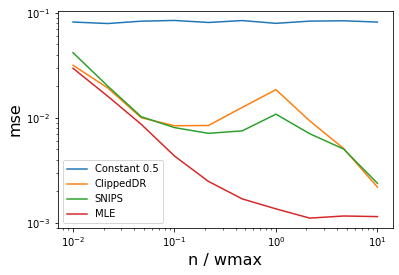

In [2]:
from importlib import reload
import MLE.MLE

reload(MLE.MLE)
  
class DoubleDouble:
    def __init__(self, numactions, seed, wsupport, expwsq):
        import numpy
        import environments.ControlledRangeVariance
        
        self.numactions = numactions
        self.state = numpy.random.RandomState(seed+1)
        self.env = environments.ControlledRangeVariance.ControlledRangeVariance(seed=seed, wsupport=wsupport, expwsq=expwsq)
        
    def range(self):
        return self.env.range()
        
    def rawsample(self, ndata):
        from collections import Counter
        (truevalue, data) = self.env.sample(ndata)
        
        nicedata = Counter()
        for c, w, r in data:
            actioncounts = Counter(self.state.choice(a=self.numactions, p=None, size=c))
            for pia, ca in actioncounts.items():
                nicedata.update({ (w, r, pia): ca })
            
        return (truevalue, [ (c, w, r, pia) for (w, r, pia), c in nicedata.items() ])
            
    def sample(self, ndata):
        from collections import Counter

        (truevalue, data) = self.rawsample(ndata)
        nicedata = Counter()
        for c, w, r, pia in data:
            nicedata.update({ (w, r): c })
        return (truevalue, [ (c, w, r) for (w, r), c in nicedata.items() ])
    
    def samplewithcvs(self, ndata):
        from collections import Counter
        import numpy

        (truevalue, data) = self.rawsample(ndata)
   
        nicedata = Counter()
    
        for c, w, r, pia in data:
            cvs = tuple(
                       w - 1 if a == pia else 0 for a in range(self.numactions)
            )
            nicedata.update({ (w, r, cvs): c})

        return (truevalue, [ (c, w, r, numpy.array(cv)) for (w, r, cv), c in nicedata.items() ])

def getenv():
    ddm = DoubleDouble(numactions=2, seed=5, wsupport=[0, 2, 1000], expwsq=100)
    return (ddm, 1000)

from pprint import pformat
print(pformat(getenv()[0].rawsample(20)))
print(pformat(getenv()[0].sample(20)))
print(pformat(getenv()[0].samplewithcvs(20)))

FlassPlot.forpaper()
wmax = getenv()[1]
for (name, method) in [ ('Constant 0.5', lambda **kwargs: 0.5),
                        ('ClippedDR', ClippedDR.estimate),
                        ('SNIPS', SNIPS.estimate),
                        ('MLE', lambda data, **kwargs: MLE.MLE.estimate(datagen=lambda: data, **kwargs)[0]),
                      ]:
    print('****** {} ******'.format(name))
    res = []
    for zzz in produceresults(getenv()[0], method, maxexp=4, numpts=10, ndataperpt=1000):
        res.append(zzz)
        #print('{}'.format(zzz), flush=True)
    FlassPlot.pic([ x[0] / wmax for x in res], [ x[1]['mse'] for x in res], label=name)
FlassPlot.axeslabel('n / wmax', 'mse')
# FlassPlot.title('synthetic epsilon-greedy: estimation error')
#FlassPlot.savefig('epsilongreedy.mse.pdf')